# Анализ оттока клиентов сети фитнес-центров «Культурист-датасаентист»

## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.  

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? 

Индикаторы оттока зависят от специфики отрасли: <b>для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал</b>.   

Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.  
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

Необходимо:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента; 
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  
- проанализировать основные признаки, наиболее сильно влияющие на отток;  
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
    1) выделить целевые группы клиентов;  
    2) предложить меры по снижению оттока;  
    3) определить другие особенности взаимодействия с клиентами.  

## Загрузка библиотек

In [1]:
# загрузим все нужные библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

#ML
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.simplefilter('ignore')
sns.color_palette("husl", 8)
sns.set_style("whitegrid")
pd.options.display.max_colwidth = 130

## Описание данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. 

Данные клиента за предыдущий до проверки факта оттока месяц:
- <b>gender</b> — пол;
- <b>Near_Location</b> — проживание или работа в районе, где находится фитнес-центр;
- <b>Partner</b> — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- <b>Promo_friends</b> — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- <b>Phone</b> — наличие контактного телефона;
- <b>Age</b> — возраст;
- <b>Lifetime</b> — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- <b>Contract_period</b> — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- <b>Month_to_end_contract</b> — срок до окончания текущего действующего абонемента (в месяцах);
- <b>Group_visits</b> — факт посещения групповых занятий;
- <b>Avg_class_frequency_total</b> — средняя частота посещений в неделю за все время с начала действия абонемента;
- <b>Avg_class_frequency_current_month</b>  — средняя частота посещений в неделю за предыдущий месяц;
- <b>Avg_additional_charges_total</b> — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- <b>Churn</b> — факт оттока в текущем месяце.

## Исследовательский анализ данных (EDA)

### Первичный анализ датасета

- есть ли в нем отсутствующие признаки  
- изучите средние значения  
- изучите стандартные отклонения 

пригодится метод describe()

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

df.sample(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1250,0,1,0,0,1,1,0,29,131.401030,1.0,16,0.274207,0.271249,0
1725,1,1,0,0,1,1,0,28,28.578690,1.0,3,2.193724,1.984109,0
102,0,1,1,1,1,1,0,33,16.749150,1.0,1,2.911744,2.944011,0
3889,1,1,1,1,1,12,0,26,85.325733,3.0,4,1.766439,1.675791,0
3500,0,1,0,0,1,1,0,25,272.614007,1.0,0,2.641714,3.540271,1
1561,0,1,0,0,1,1,1,34,109.354667,1.0,4,0.652188,0.505271,0
2520,1,1,1,0,1,12,0,30,248.185911,12.0,5,1.872142,1.834113,0
2580,1,1,1,1,1,1,0,30,123.292793,1.0,9,3.296184,3.431796,0
2247,0,0,0,0,1,1,1,29,106.846408,1.0,2,1.949132,2.066673,0
523,0,1,0,0,1,1,1,33,187.075893,1.0,2,1.870808,1.688062,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
print(f'Количество дубликатов df {df.duplicated().sum()}')

Количество дубликатов df 0


<font color='orange'><b>*Наблюдение_*</b></font>

- пустых значений нет
- явных дубликатов нет
- переведем названия столбцов в snake_register

In [5]:
df.columns = df.columns.str.lower()

In [6]:
numeric_columns = df.describe().T.drop(columns=['count', '25%', '50%', '75%']).columns

df.describe().T.style.format({'mean': '{:.2f}', 'std': '{:.2f}', 'min':'{:.2f}', '25%':'{:.2f}', 
                              '50%':'{:.2f}', '75%':'{:.2f}', 'max':'{:.2f}', 'count':'{:.2f}'}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


In [7]:
# посмотрим на уникальные значения столбцов для более точной интерпретации результатов функции описательной статистики

for column in df.columns:
    print(f'столбец {column}: {df[column].unique()},\nколичество уникальных значений {df[column].nunique()}')
    print('='*80)

столбец gender: [1 0],
количество уникальных значений 2
столбец near_location: [1 0],
количество уникальных значений 2
столбец partner: [1 0],
количество уникальных значений 2
столбец promo_friends: [1 0],
количество уникальных значений 2
столбец phone: [0 1],
количество уникальных значений 2
столбец contract_period: [ 6 12  1],
количество уникальных значений 3
столбец group_visits: [1 0],
количество уникальных значений 2
столбец age: [29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41],
количество уникальных значений 23
столбец avg_additional_charges_total: [ 14.22747042 113.20293765 129.44847933 ...  78.25054157  61.91265691
 178.86181361],
количество уникальных значений 4000
столбец month_to_end_contract: [ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.],
количество уникальных значений 12
столбец lifetime: [ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29],
количество уникальных значений 29
столбец avg_class_frequency_total: [

<font color='orange'><b>*Наблюдение_*</b></font>

- gender - всего есть два пола, обозначанную 1 и 0. По среднему и медиане можно предположить, что полов поровну. 
- near_location - всего два варианты выбора "проживание/работа в районе, где находится фитнес-центр" - 0 и 1 (предположительно да и нет). По среднему и 0,25-квантилю можно сделать вывод, что преобладают посетители, которые живту/работаю рядом с клубом   
- partner - опять два вариант - или сотрудник компании-партнёра клуба или нет - 1 и 0. По стандартному значению и 0,75-квантилю выходит, что немного преобладают посетители, компании которых не являются партнерами клуба.
- promo_friends - так же два значения - привел друга или нет - 1 и 0. Опять таки, по среднему и 0,75-квантилю можно говорить, что людей, пришедших по акции - меньшинство        
- phone - опять два значения - есть телефон или нет - 1 и 0. У большиснтва людей есть контактный телефон.
- contract_period - длительность договора соотвествует заявленной - 1, 6 и 12 месяцев. Тут не могу интерпретировать значения, так как стандартное отклоенение и среднее равны, а медиана в разы меньше, чем среднее. По медиане, половине людей заключает договор на 1 месяц.
- group_visits - факт посещения груповых занятий - или да или нет -1 и 0. Чуть больше людей посещают групповые занятия.  
- age - уникальный значений 23 - с 18 лет до 41 года. Половина людей в возрасте 30 лет.   
- lifetime - время с момента первого обращения в фитнес-центр (в месяцах) - всего уникальных значений 29 - от 0 дней до 31 дня (пропущены 25, 28 и 30 дневный срок - интересный факт, не знаю с чем связать...). Половина людей в датасете - первый раз посетили зал 3-4 месяца назад.  
- churn - факт оттока в текущем месяце - значений всего два - перестал посещять зал или нет - 0 и 1. Большиснтво людей уходят. 
- avg_additional_charges_total - суммарная выручка от других услуг фитнес-центра - в среднем, на доп услугах с одного посетителя выходит 140-150 USD(?)
- month_to_end_contract - срок до окончания текущего действующего абонемента (в месяцах) - всего 12 месяцев и 12 значений - от 1 до 12. Ситуация похожая для contract_period
- avg_class_frequency_total - средняя частота посещений в неделю за все время с начала действия абонемента - в среднем на одного посетителя выходит 2 посещения в неделю
- avg_class_frequency_current_month - средняя частота посещений в неделю за предыдущий месяц - в среднем, за прошлый месяц люди так же были около двух раз в зале

<b>Наша целевая переменная - churn</b>

### Средние значения признака churn в двух группах

-тех, кто ушел в отток и тех, кто остался  
воспользуйтесь методом groupby()

In [8]:
features_mean_chu = df.groupby('churn').mean().T.applymap("{:.2f}".format)
features_mean_chu = features_mean_chu.rename(columns={0: 'active_users',
                                                      1: 'left_users'})
features_mean_chu

churn,active_users,left_users
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


<font color='orange'><b>*Наблюдение_*</b></font>

- возраст и пол не имзенились
- тенденция для локации так же сохранилась, но стала чуть ниже - значит, люди живут чуть дальше из группы оттока
- видим, что в оттоке, людей, которые не имеют скидок от партнеров - больше
- пришедших по приглашению друзей, в оттоке меньше
- наличие контактного телефона не повлияло
- в оттоке, люди чаще брали пробный абонемент (1 месяц), в активные пользователи обычно выбирают полгода
- групповые занятия больше предпочитают активные пользователи
- пользователи оттока предпочитают не тратиться 
- по значению остатков месяцев до окончания договора времени столько же, сколько сейчас для contract_period	- значит, датасет совсем свежий?
- в среднем ушедшие пользователи занимаются не больше 1 месяца
- количество посещений в предыдущем месяце в два раза ниже у клиентов в оттоке, как и в случае средней частоты посещения зала

Возможно, люди из оттока уходят за более выгодными предложениями (близость к работе/дому, скидки) после месяца апробации.

### Cтолбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

Для признаков, которые не содержать всего два или три значения (0, 1 и 1, 6, 12), мы построим гистрограмы с гауссовской  кривой. Для бинарных признаков, логичнее построить столбчатые диаграммы.

### Гистограммы

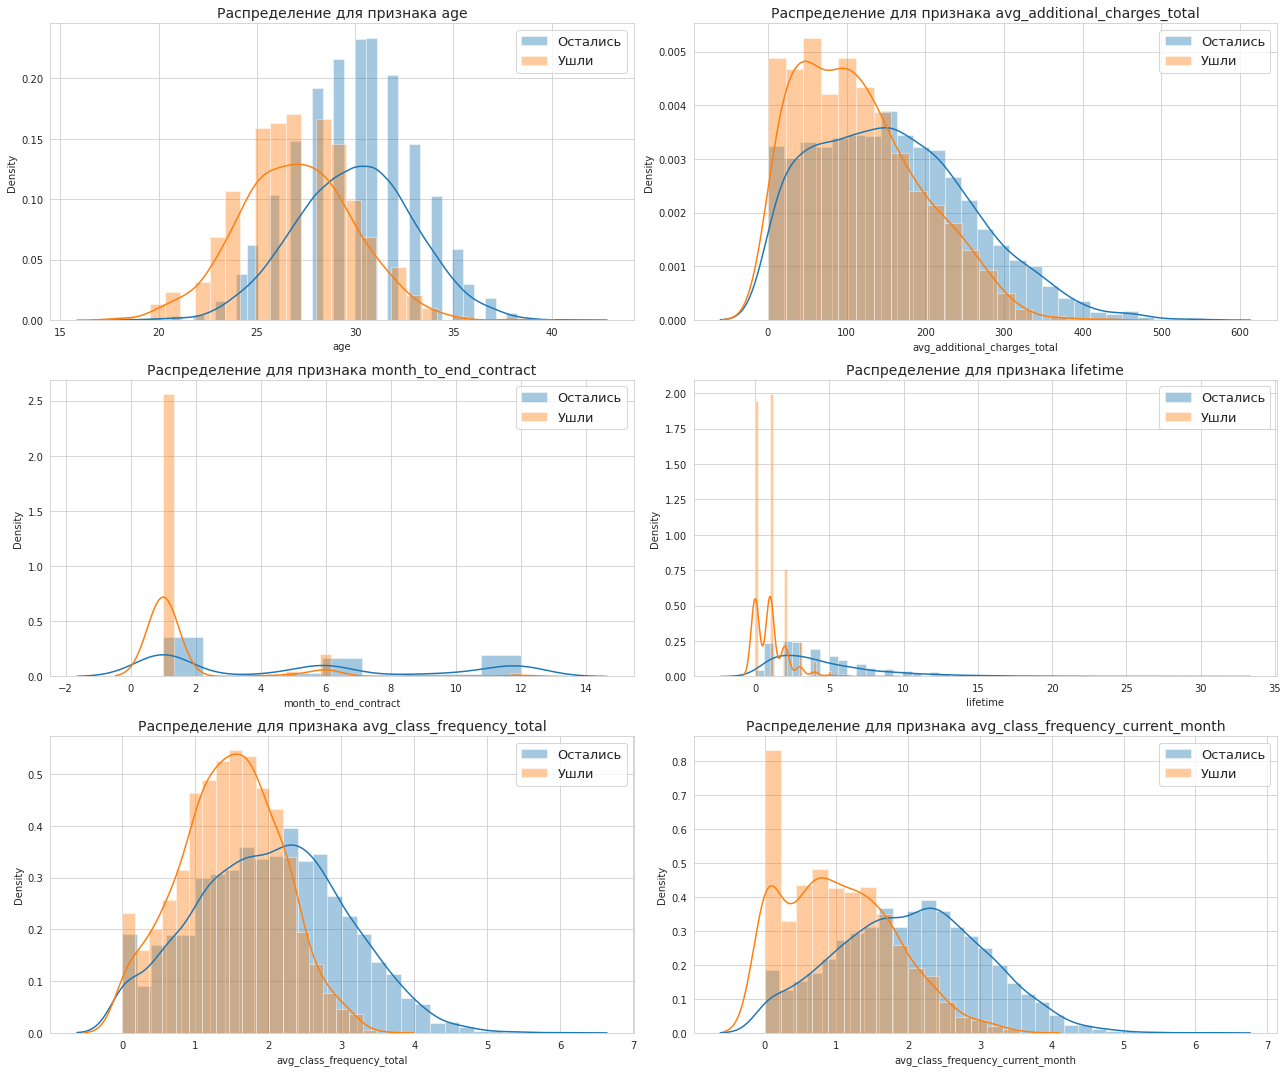

In [9]:
# select the columns to be plotted
cols = df.drop(columns=['gender', 'near_location', 'partner', 
                                'promo_friends', 'phone', 'group_visits', 'churn', 'contract_period']).columns   

# create the figure and axes
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.distplot(df[df['churn']==0][col], ax=ax, label='Остались')
    sns.distplot(df[df['churn']==1][col], ax=ax, label='Ушли')
    ax.set_title(f'Распределение для признака {col}',fontsize=14)
    ax.legend(fontsize=13)

fig.tight_layout()
plt.show()

<font color='orange'><b>*Наблюдение_*</b></font>

- центр гистограммы для ушедщих смещен левее, а значит уходят чаще молодые
- ушдещие чаще тратят меньше суммы, чем оставшиеся
- клиенты в оттоке чаще покупают абонемент на 1 месяц
- уходят в основном пользователи, которые проходили до 5 месяцев
- клиенты в оттоке посещяют зал 1-2 раза в неделю
- если клиент в этом месяце не пришел, то вероятнее всего он не вернется. Если посетил больше 4-х раз за одну неделю - он скорее всего станет постоянным клиентом

### Столбчатые диаграммы

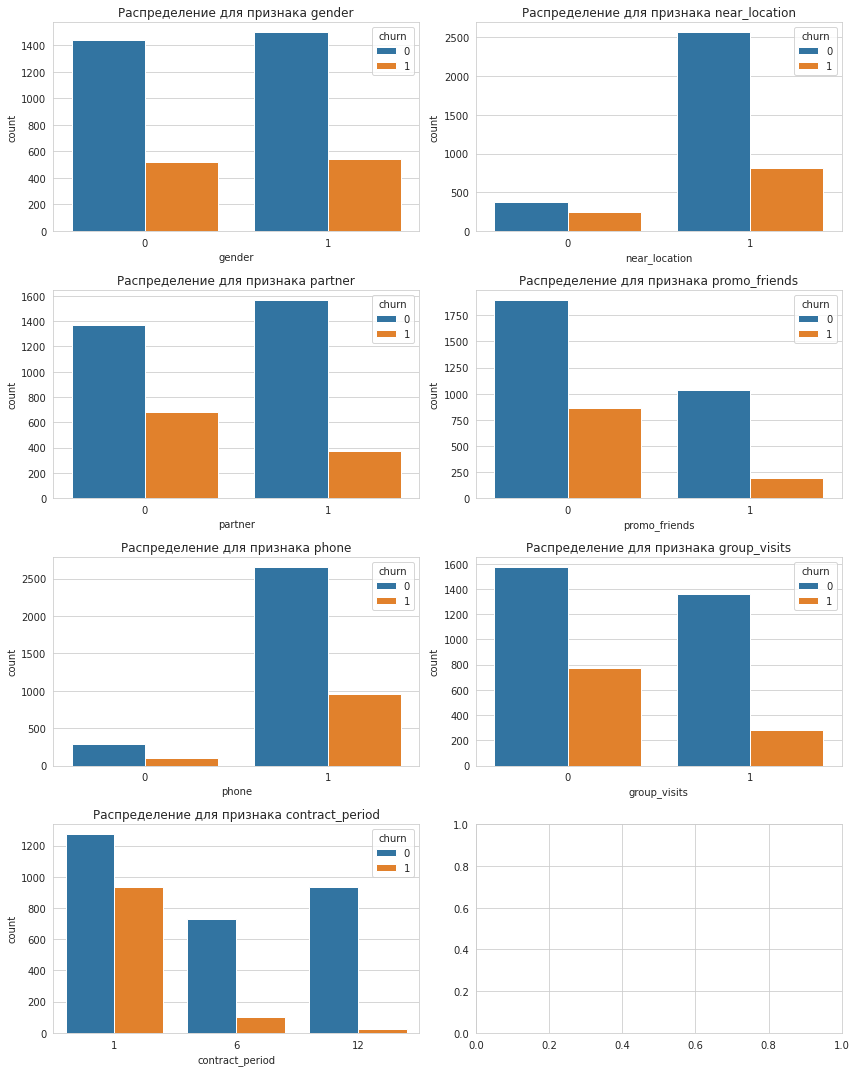

In [10]:
# select the columns to be plotted
cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'contract_period']

# create the figure and axes
fig, axes = plt.subplots(4, 2, figsize=(12, 15))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.countplot(x = df[col], hue='churn', data=df, ax=ax)
    ax.set_title(f'Распределение для признака {col}',fontsize=12)
    plt.subplots_adjust(wspace=0.10, hspace=0.10)

fig.tight_layout()
plt.show()

<font color='orange'><b>*Наблюдение_*</b></font>

- уходят в равной степени мужчины и женщины
- яркой зависимости уходящих от наличия фитнеса около дома или нет не вижу, так как доли я бы сказала равны
- чаще уходят те, у кого нет партнерских скидок и промо от друзей (доли отличаются примерно в два раза)
- нет разницы, оставил человек контактный номер или нет (доли почти одинаковые)
- уходят чаще те, кто не посещал груповые занятия
- те, кто уходят в будущем, предпочитают оформалять абонемент на 1 месяц

### Матрица корреляций

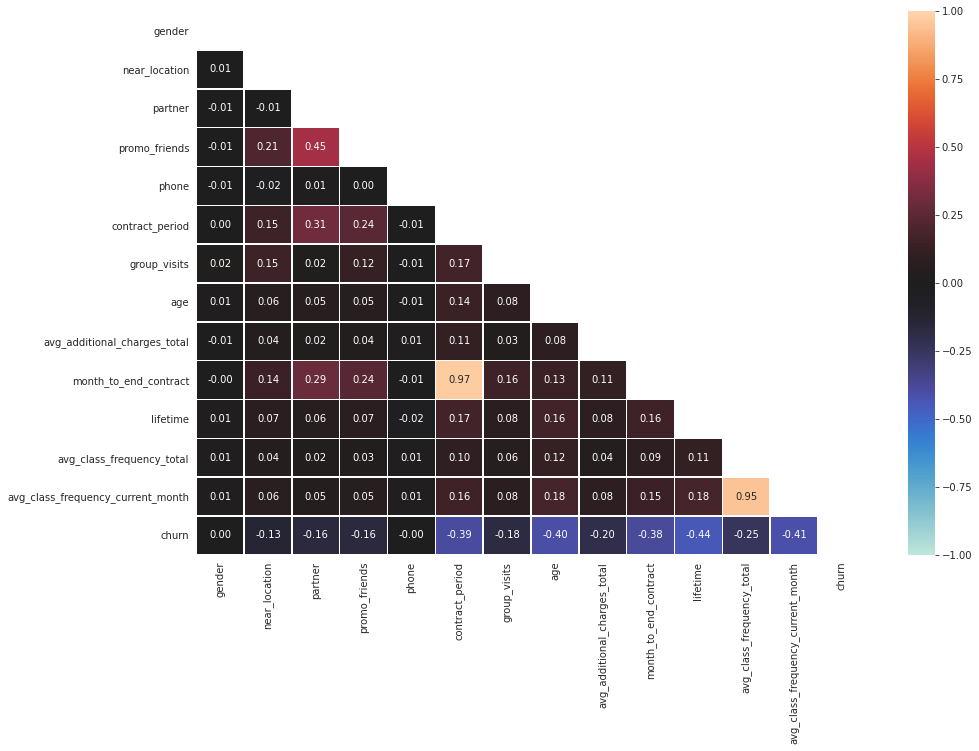

In [17]:
matrix = np.triu(df.corr())
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, mask=matrix, fmt = '0.2f', linewidths=.5, vmin=-1, vmax=1, center= 0)
#sns.heatmap(corr_matrix , annot = True, fmt = '0.2f', linewidths=.5, vmin=-1, vmax=1, center= 0)
plt.show()


<font color='orange'><b>*Наблюдение_*</b></font>

- видна сильная корреляция между avg_class_frequency_total и avg_class_frequency_current_month (0.95) и между month_to_end_contract и contract_period (0.97), что логично, так как признаки сввязаны. Можно назвать эти признаки мультиколлинеарными (взаимозависимые или очень сильно скоррелированные признаки).  
- Так же выделяется корреляция между  promo_friends и partner (0.45). Возможно, сотрудники партнеров чаще приглашают своих друзей, чем остальные
- сильной корреляции целевой перменной churn с признаками не выявлено, но можно сделать след выводы:   
    1) отток совсем не зависит от пола и наличия контактного номера  
    2) максимально влияющие признаки - время с первого обращения в фитнес (-0.44), среднее количество посещений в месяц, возраст и длительного тек. договора. Все они отрицательно коррелированы с оттоком - чем  меньше отток, тем больше значения этих переменных.  

### Вывод

Можно предположить, что портрет пользователя в оттоке выглядит так:
- средний возраст около 27 лет
- оформляют договор на 1 месяц
- мало производят сопутствующих трат
- посещают фитнес около 1-2 раз в неделю
- не посещают групповые занятия
- нет имеют скидок

## Модель прогнозирования оттока клиентов

Бинарная классификация – это один из типов задач классификации в машинном обучении, когда мы должны классифицировать два взаимоисключающих класса.

<b>Логистическая регрессия</b>   
Несмотря на свое название, логистическая регрессия – это очень простой алгоритм классификации и один из самых эффективных классификаторов машинного обучения для задач бинарной классификации. Некоторые из преимуществ логистической регрессии для бинарной классификации заключаются в том, что ее проще реализовать и очень эффективно обучать. Одним из недостатков этого алгоритма является то, что на него влияют выбросы.  

<b>Случайный лес</b>  
Если ваш набор данных содержит выбросы, вам нужен мощный алгоритм, на который не могут повлиять выбросы. Алгоритм дерева решений – настолько мощный алгоритм, что его можно использовать в задачах классификации любого типа, не подвергаясь влиянию выбросов. Одним из преимуществ алгоритма классификации дерева решений является то, что он требует очень простой подготовки данных, поскольку на него не влияют выбросы.  

<b>Алгоритм Бернулли наивного байесовского классификатора</b>   
Алгоритм Бернулли наивного байесовского концентратора – это одна из разновидностей алгоритма наивного байесовского концентратора, очень полезная в задаче бинарной классификации. Вот некоторые из преимуществ использования этого алгоритма для бинарной классификации: 
- очень быстрый по сравнению с другими алгоритмами классификации;
- может хорошо работать как с большими, так и с маленькими наборами данных;
- также может легко обрабатывать нерелевантные функции.

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

### Разбивка данных на обучающую и валидационную выборку 

- Используйте функцию train_test_split()
- Не забудьте указать параметр random_state при разделении выборки и задании алгоритма.

In [18]:
X = df.drop('churn', axis = 1)
y = df['churn']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# стандартизируем значение признаков, чтобы уменьшить MSE и вес мультиколлинеарных признаков

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [20]:
# check

for i in (X_train, X_test, y_train, y_test):
    print(f'{i.shape}')

(3200, 13)
(800, 13)
(3200,)
(800,)


In [21]:
# посмотрим на среднее средних и среднее стандартное отклонение до стандартизации

for i in [X_train, X_test]:
    print(f'Mean for train\n{np.mean(i).mean()}')
    print(f'Std for train\n{np.std(i).mean()}')
    print('='*50)

Mean for train
14.97235915687111
Std for train
9.004854446550603
Mean for train
15.48337081244844
Std for train
8.859870519026526


In [22]:
# посмотрим, как изменилось среднее и стандартное отклонение после стандартизации

for i in [X_train_st, X_test_st]:
    print(f'Mean for train\n{np.mean(i[:,0])}')
    print(f'Std for train\n{np.std(i[:,0])}')
    print('='*50)

Mean for train
-9.43689570931383e-17
Std for train
1.0000000000000002
Mean for train
0.015002297402698064
Std for train
0.9996248147390785


<font color='orange'><b>*Наблюдение_*</b></font>

- стандартизация сработала корректно

### Обучиние модели на train-выборке и оценка метрик

- логистической регрессией,
- случайным лесом
+ алгоритм Бернулли наивного байесовского классификатора*

In [23]:
# список моделей

models = [
    LogisticRegression(solver='liblinear', random_state=0),
    RandomForestClassifier(random_state=0),
    BernoulliNB(binarize=0.0),   
]


def make_model_evaluation(m, X_train, y_train, X_test, y_test):
    
    '''
    функция принимает на вход модель и данные обучающей и валидационной выборкок и выводит метрики для оценки работы модели
    
    '''
    
    model = m
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    print('Accuracy:{:.2f}\nPrecision:{:.2f}\nRecall:{:.2f}\nF1:{:.2f}\nROC_AUC:{:.2f}'.format(
        accuracy_score(y_test, predictions),
        precision_score(y_test, predictions), 
        recall_score(y_test, predictions), 
        f1_score(y_test, predictions),
        roc_auc_score(y_test, probabilities)))

In [24]:
# цикл, который выводит метрики по списку моделей

for i in models:
    print(i)
    make_model_evaluation(i, X_train_st, y_train, X_test_st, y_test)
    print('='*50)

LogisticRegression(random_state=0, solver='liblinear')
Accuracy:0.94
Precision:0.90
Recall:0.85
F1:0.87
ROC_AUC:0.98
RandomForestClassifier(random_state=0)
Accuracy:0.92
Precision:0.88
Recall:0.83
F1:0.85
ROC_AUC:0.97
BernoulliNB()
Accuracy:0.87
Precision:0.73
Recall:0.80
F1:0.76
ROC_AUC:0.92


<font color='orange'><b>*Наблюдение_*</b></font>

- доля правильных ответов и кривая олшибок одинаково высоки для лог. регрессии и случайного леса
- точность, полнота и соблюдение баланса между ними немного лучше у регрессии 
- алгоритм Бернулл с треском провалился

В итоге, наилучшая модель для нашей задачи - логистическая регрессия.

In [25]:
# обучим финальную модель

final_model = LogisticRegression(solver='liblinear', random_state=0)
final_model.fit(X_train_st, y_train)

y_pred = final_model.predict(X_test_st)

# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности

lg_df = pd.DataFrame({'feature': X_train.columns, 'coeff': final_model.coef_[0]})
lg_df['coeff_abs'] = abs(lg_df['coeff'])
lg_df.sort_values(by='coeff_abs', ascending=False)

,feature,coeff,coeff_abs
12,avg_class_frequency_current_month,-4.189012,4.189012
10,lifetime,-3.471939,3.471939
11,avg_class_frequency_total,3.105587,3.105587
7,age,-1.148928,1.148928
5,contract_period,-0.687710,0.687710
9,month_to_end_contract,-0.617235,0.617235
8,avg_additional_charges_total,-0.560866,0.560866
6,group_visits,-0.393328,0.393328
3,promo_friends,-0.139599,0.139599
2,partner,-0.068231,0.068231


In [26]:
# уберем два сильно колеррирующих признака для болеее адекватной оценки весов признаков 
# можно убрать люой из двух (если я верно поняла) - мне кажется логичнее убрать тот, который охватывает меньшее пространство-
# месяцев до окончания договора и среднее колдичество посщений в месяц

final_model_check = LogisticRegression(solver='liblinear', random_state = 0)
X_train_check = X_train.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)
final_model_check.fit(X_train_check, y_train)

log_reg_check = pd.DataFrame({'feature' : X_train_check.columns, 'coeff' : final_model_check.coef_[0]})
log_reg_check['coeff_abs'] = abs(log_reg_check['coeff'])
log_reg_check.sort_values(by='coeff_abs', ascending=False)

,feature,coeff,coeff_abs
9,lifetime,-0.911632,0.911632
6,group_visits,-0.628991,0.628991
10,avg_class_frequency_total,-0.589678,0.589678
3,promo_friends,-0.352993,0.352993
5,contract_period,-0.276929,0.276929
7,age,-0.212865,0.212865
0,gender,0.110379,0.110379
4,phone,0.075595,0.075595
2,partner,0.031050,0.031050
1,near_location,0.027865,0.027865


<font color='orange'><b>*Наблюдение_*</b></font>

- как и в таблице корреляции наиболее весомые признаки обратнопропорционально связаны с оттоком.
- в лидерах остались lifetime, avg_class_frequency_total (вместо удаленного сильно связанного month). Теперь group_visits имеет больший вес, чем возраст

### Вывод

- Лучший результат показала логистичекая регрессия
- Больший вес у таких признаков как время с первого обращения в фитнес, групповые занятия, среднее количество посещений (всего или в месяц), скидки и возраст.

##  Кластеризация клиентов

- Отложим в сторону столбец с оттоком и стандартизируем данные
- Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить
- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. 
Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта)

In [27]:
# удалим столбец 'churn'

df_sс = df.drop(['churn'], axis=1)
df_sс.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078


In [28]:
# стандартизируем значение признаков

scaler = StandardScaler()
X_st = scaler.fit_transform(df_sс)

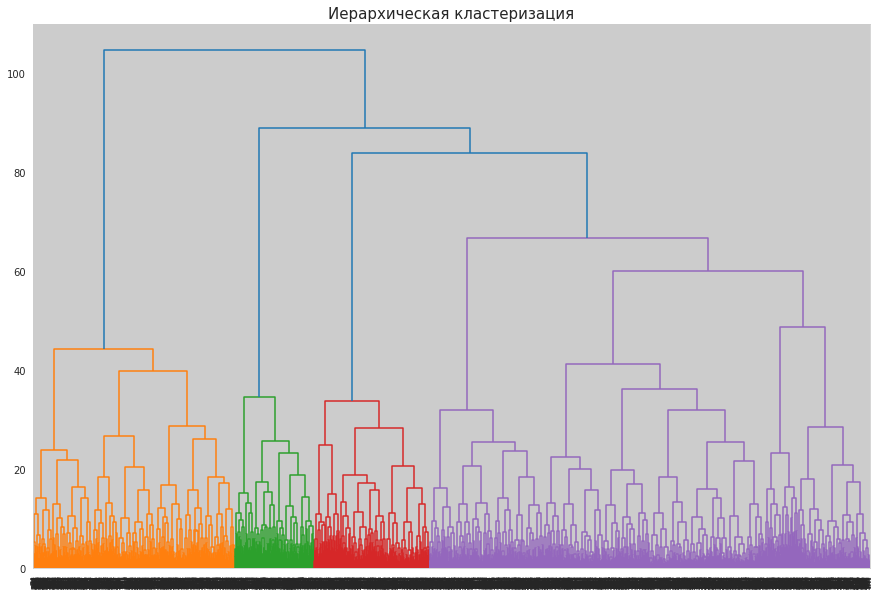

In [29]:
# строим дендограмму

linked = linkage(X_st, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация', fontsize=15)
plt.show()

<font color='orange'><b>*Наблюдение_*</b></font>

- видно 4 кластера, по заданию будем делить на 5

In [30]:
# делим df_clus (копию) на клакстеры

km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_st)

df_clust = df.copy(deep=True)
df_clust['cluster'] = labels

In [31]:
# посмотрим как распределены пользователи по кластерам

df_clust.cluster.value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster, dtype: int64

<font color='orange'><b>*Наблюдение_*</b></font>

- самый большой кластр - 3, самый маленький - 1

###  Средние значения признаков для кластеров

- Можно ли сразу что-то заметить?

In [32]:
#выводим статистику по средним значениям наших признаков по кластеру

cluster_features = df_clust.groupby('cluster').mean().reset_index()

numeric_columns = cluster_features.drop(columns=['cluster', 'gender']).columns

cluster_features.style.format({'gender': '{:.2f}', 'near_location': '{:.2f}', 'partner': '{:.2f}', 
                                'promo_friends': '{:.2f}', 'phone': '{:.2f}', 'contract_period': '{:.2f}',
                                'group_visits': '{:.2f}', 'age': '{:.2f}', 'avg_additional_charges_total': '{:.2f}', 
                                'month_to_end_contract': '{:.2f}', 'lifetime': '{:.2f}', 'churn': '{:.2f}', 
                                'avg_class_frequency_total': '{:.2f}', 'avg_class_frequency_current_month': '{:.2f}'}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

,cluster,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


<font color='orange'><b>*Наблюдение_*</b></font>

Описание кластеров:

> 0 кластер  
- самый низкий отток - 3%  
- самое большое количество месяцев до окончания договора/заключенного договора - 10
- самый высокий индикатор посещения груповвых занятий и скидок

> 1 кластер
- третий по оттоку клиентов
- средние показатели по всем признакам
- в среднем не осталвяют контактный номер

> 2 кластер
- второй по оттоку клиентов
- в среднем все клиенты не работают/живут около фитнеса
- в среднем нет купона от друзей (а значит и скидок)
- самый низкий процент посещения групповых занятий

> 3 кластер
- самый высокий отток - 51%  
- в среднем все клиенты в этом кластаре работают/живут около фитнеса
- в среднем нет скидки от компании-партнера
- самый низкий срок договора/окончание договора - до 2 месяцев
- самый маленький возраст
- самый низкий показатель доп. покупок
- самый короткий срок после первого посещения фитнеса - 2 месяца
- самая низкая частота посещения зала - 2 раза

> 4 кластер
- самый большой возраст
- самое большой показатель доп трат
- самый высокий lifetime
- самый длинный срок после первого посещения фитнеса - 5 месяцев
- самая высокая частота посещения зала - 3 раза

###  Гистограмма распределения признаков для кластеров
- Можно ли что-то заметить по ним?

Так как 4 гистограммы будут смотреться скученно, то возьму только гауссовскую кривую.

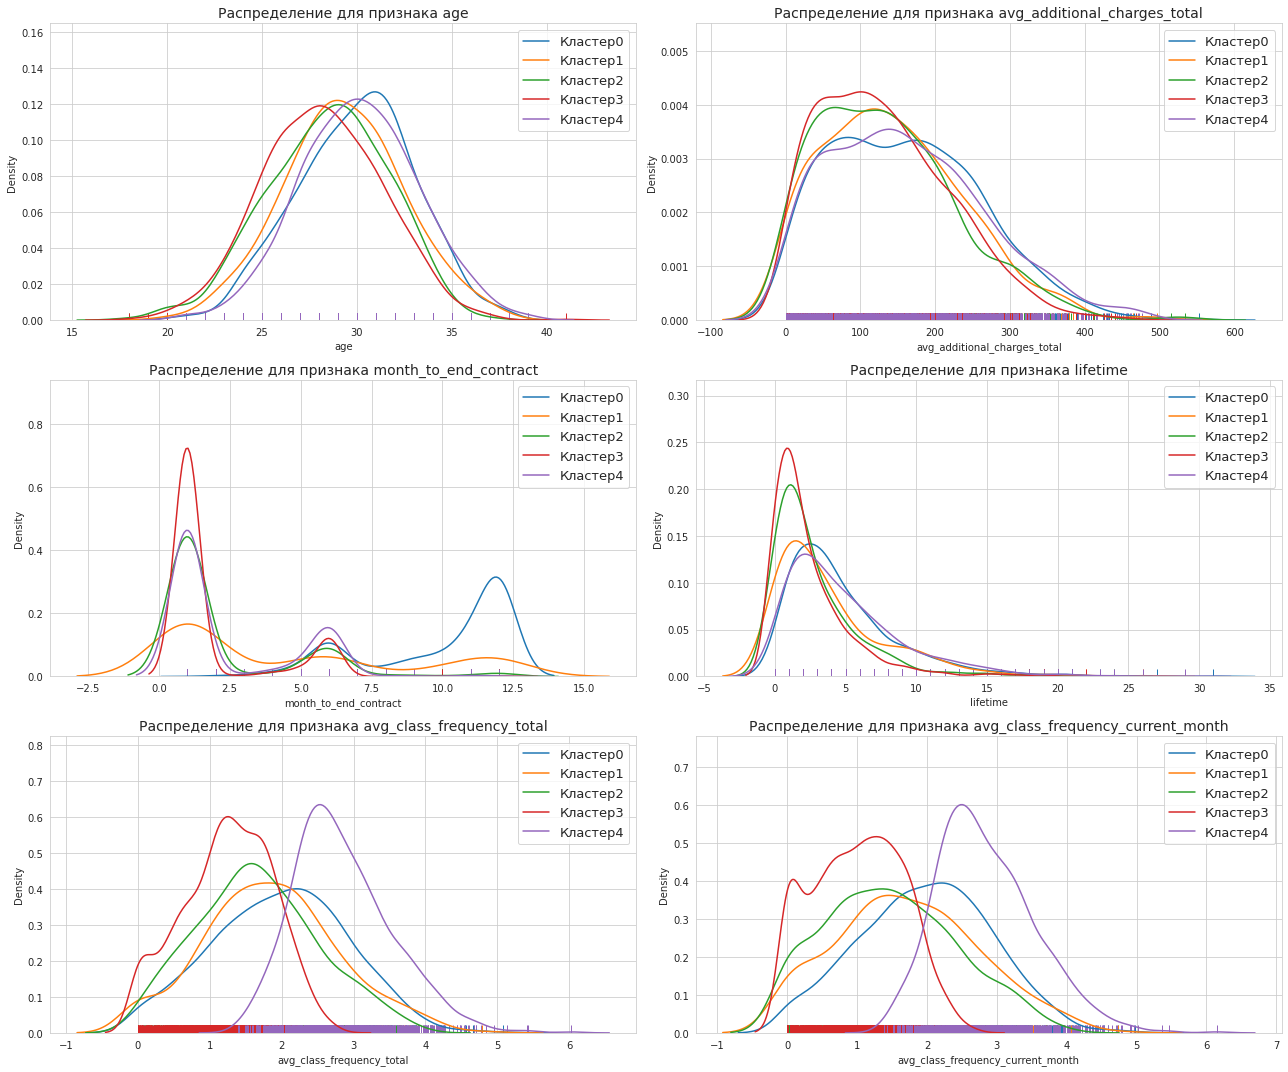

In [33]:
# select the columns to be plotted
cols = df_clust.drop(columns=['gender', 'near_location', 'partner', 
                                'promo_friends', 'phone', 'group_visits', 'churn', 'contract_period', 'cluster']).columns    

# create the figure and axes
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    for i in range(0,5):
        sns.distplot(df_clust.query('cluster == @i')[col],
                    hist=False,
                    rug=True,
                    kde_kws={'label':'Кластер'+ str(i)}, ax=ax)
        ax.set_title(f'Распределение для признака {col}',fontsize=14)
        ax.legend(fontsize=13)  
    
fig.tight_layout()
plt.show()

<font color='orange'><b>*Наблюдение_*</b></font>

В предидущем пункте мы увидели, что 3 кластер - лидер по оттоку, 0 - лидер по сохранению пользователей. Будем ориентитроваться в анализе на них.
- К оттоку склоны молоджые люди (3 кластер), старые - склонны оставаться ( 0 кластер)
- 3 кластер чаще тратит меньше чем все остальные
- ушедщие пользователи предпочитают договоры на 1 месяц
- для 2-го и 3-го кластера lifetime самый короткий
- в среднем уходящие пользователи посещают зал до 3 раз в неделю, если посещений больше 4-х - скорее всего пользователь будет постоянным

###  Столбчатая диаграмма распределения признаков для кластеров (бинарных)

- Можно ли что-то заметить по ним?

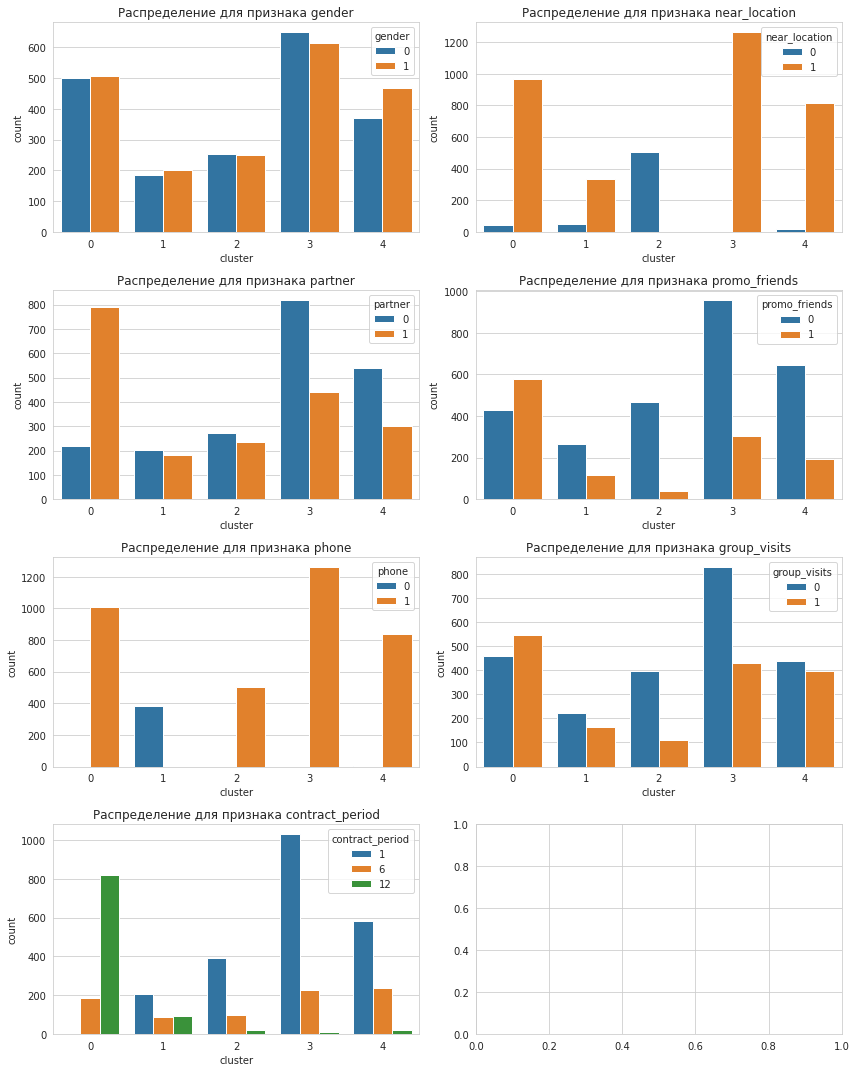

In [34]:
# select the columns to be plotted
cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'contract_period']

# create the figure and axes
fig, axes = plt.subplots(4, 2, figsize=(12, 15))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.countplot(x ='cluster', hue=col, data=df_clust, ax=ax)
    ax.set_title(f'Распределение для признака {col}',fontsize=12)
    plt.subplots_adjust(wspace=0.10, hspace=0.10)

fig.tight_layout()
plt.show()

<font color='orange'><b>*Наблюдение_*</b></font>

- во всех, кроме 4-ой группы, распределение полов равное
- все пользователи 3го кластера - живут не рядом с фитнесом, а все из 2-го кластера - рядом
- большиснтво людей из 0 кластера имеют скидки от партнера-компании/промокод от друга, а вот из 3-го кластера наоборот
- клиенты из всех кластеров, кроме 1-го, отсалвяют контактынй номер
- люди из 3-го кластера чаще всех не посещают групповые занятия
- самый короткий период чаще всех выбирают люли из 3-его кластера, самы йдлинный - из 0

###  Доля оттоков для каждого полученного кластера

- методом groupby() 
- Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [35]:
share_clust = df_clust.groupby('cluster').agg({'churn':'mean'}).sort_values(by='churn', ascending=False).reset_index()
share_clust.style.format({'churn': '{:.2%}'})

,cluster,churn
0,3,51.43%
1,2,44.36%
2,1,26.75%
3,4,6.80%
4,0,2.77%


In [36]:
# check

df_clust.query('cluster == 3')['churn'].value_counts()/df_clust.query('cluster == 3')['churn'].count()

1    0.514263
0    0.485737
Name: churn, dtype: float64

<font color='orange'><b>*Наблюдение_*</b></font>

- самый надежные кластеры - 0 и 4
- самый большой отток у 3-го кластера

### Вывод

- Мы првели кластеризацию клиентов по всем признакам, выявили 4 явные группы, раздели на 5 (по заданию).  
- В итоге в 3-ий кластер попали пользователи, которые имеют тенденцию уходить.
- В 0 и 4-ый кластеры попали люди, которые надежны и большинство являются постоянными пользователями.

##  Общий вывод 

Сформулируйте основные выводы и предложите рекомендации для стратегии взаимодействия с клиентами и их удержания.

Мы проанализировали данные клиентов фитнес клуба, чтобы выявить их основные причины ухода и выявили следующее:  
1) Предоставленный датасет не имел пустых значений и явных дубликатов   
2) Для оценки распределения признаков для ущедщих и оставшихся клиентов были использованы столбчатые диаграммы и гистограммы:   
    - уходят чаще молодые  
    - ушдещие чаще тратят меньше суммы, чем оставшиеся  
    - клиенты в оттоке чаще покупают абонемент на 1 месяц  
    - уходят в основном пользователи, которые проходили до 5 месяцев  
    - клиенты в оттоке посещяют зал 1-2 раза в неделю   
    - если клиент в этом месяце не пришел, то вероятнее всего он не вернется  
    - если посетил больше 4-х раз за одну неделю - он скорее всего станет постоянным клиентом  
    - уходят в равной степени мужчины и женщины  
    - яркой зависимости уходящих от наличия фитнеса около дома или нет   
    - чаще уходят те, у кого нет партнерских скидок и промо от друзей (доли отличаются примерно в два раза)  
    - нет разницы, оставил человек контактный номер или нет (доли почти одинаковые)  
    - уходят чаще те, кто не посещал груповые занятия  
3) по матрице корреляции выявлено, что максимально влияющие признаки на отток- время с первого обращения в фитнес, среднее количество посещений в месяц, возраст и длительного тек. договора   
4) были обучены три модели машшиного обучения для прогнозирования оттока клиентов: логистическая регрессия, случайный лес и алгоритм Бернулли наивного байесовского классификатора. По метрикам Accuracy, Precision, Recall, F1 и ROC_AU наилучшие результаты показала логистическая регрессия. Дальнейший анализ шел по этой модели  
5) подобрав оптимальную моджель для прогнозирования оттока, выявили, что наибольший вес имеют: время с первого обращения в фитнес, групповые занятия, среднее количество посещений (всего или в месяц), скидки и возраст  
6) разделили пользователей на 5 кластеров и выявили, что в 3-ем кластаре собраны все значения признаков, дающие отток клиентов. В 0 и 4 кластаре отток наименьший, что говорит о том, что сочетание таких значений признаков, как в этих кластерах, благоприятно влияет на поведение клиентов   

###  Базовые рекомендации по работе с клиентами

Не описывайте стратегию детально: достаточно 3-4 важных принципов и примеров их реализации в виде определённых маркетинговых действий.

- Стоит обратить внимание на молодых людей - им нужна дополнительная мотивация в виде скидок/предложений (например внедрить рассылку после 1 месяца пользования, где будут указаны "плюшки")
- Необходимо расширить варианты групповых занятий, чтобы они могли заинтерисовать молодежь или предоставить несколько групповых занятий бесплатно
- Стоит пересмотреть политику заключени договоров - возможно, стоит мин порог подписания сделать 3 месяца